In [1]:
import pandas as pd
import sqlite3
import struct
import matplotlib.pyplot as plt

# Get Data

### Get Tables from DB into DataFrame

In [2]:
conn = sqlite3.connect("books.db")
cursor = conn.cursor()

In [3]:
# Query to get table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Print table names
for table in tables:
    print(table[0])

books


In [4]:
def decode_sqlite_binary_result(cursor, rows):
    """
    Converts binary fields in SQLite rows to readable integers and returns column names.
    
    Args:
        cursor (sqlite3.Cursor): Cursor used for the query (for getting column names).
        rows (list of tuples): Rows returned from the query.

    Returns:
        tuple: (column_names, decoded_rows)
    """
    column_names = [desc[0] for desc in cursor.description]
    decoded_rows = []

    for row in rows:
        new_row = []
        for value in row:
            if isinstance(value, bytes) and len(value) == 8:
                try:
                    value = struct.unpack('<Q', value)[0]
                except struct.error:
                    pass  # Leave unchanged if unpacking fails
            new_row.append(value)
        decoded_rows.append(tuple(new_row))

    return column_names, decoded_rows


In [5]:
cursor.execute("SELECT * FROM books;")
rows = cursor.fetchall()

In [6]:
column_names, decoded_rows = decode_sqlite_binary_result(cursor, rows)

In [7]:
interactions_df = pd.DataFrame(decoded_rows, columns=column_names)

In [8]:
print(interactions_df.head)

<bound method NDFrame.head of                                                   authors  average_rating  \
0                  [{'author_id': '3041852', 'role': ''}]            4.13   
1                    [{'author_id': '19158', 'role': ''}]            4.22   
2                     [{'author_id': '5411', 'role': ''}]            4.43   
3       [{'author_id': '589328', 'role': ''}, {'author...            4.29   
4                   [{'author_id': '169159', 'role': ''}]            3.57   
...                                                   ...             ...   
199995  [{'author_id': '465863', 'role': ''}, {'author...            3.92   
199996             [{'author_id': '5827362', 'role': ''}]            3.67   
199997                [{'author_id': '3565', 'role': ''}]            3.89   
199998             [{'author_id': '7390210', 'role': ''}]            4.32   
199999               [{'author_id': '38550', 'role': ''}]            4.45   

         book_id                        genre

In [9]:
conn.close()

### Get Data from CSV

In [11]:
genres_df = pd.read_csv("cleaned-book-data/all_books_combined_200k.csv")

In [12]:
print(genres_df.head())

                                             authors  average_rating  book_id  \
0             [{'author_id': '3041852', 'role': ''}]            4.13   287141   
1               [{'author_id': '19158', 'role': ''}]            4.22  6066812   
2                [{'author_id': '5411', 'role': ''}]            4.43    89378   
3  [{'author_id': '589328', 'role': ''}, {'author...            4.29  3209312   
4              [{'author_id': '169159', 'role': ''}]            3.57  1698376   

                         genres  is_children  is_comics_graphics  \
0   children, history_biography         True               False   
1  children, fantasy_paranormal         True               False   
2                      children         True               False   
3                      children         True               False   
4                      children         True               False   

   is_fantasy_paranormal  is_history_biography  is_mystery_thriller_crime  \
0                  False   

# EDA

### for user_interactions

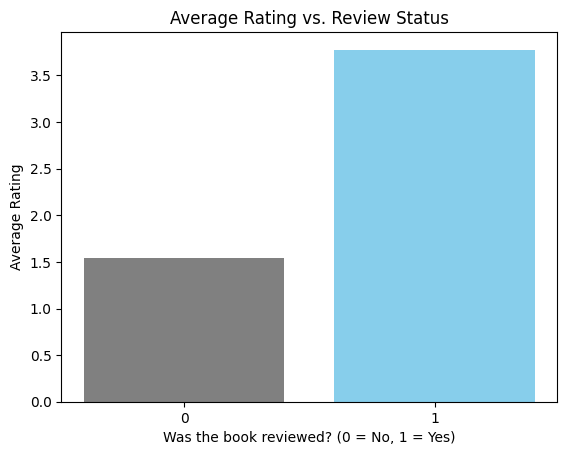

In [10]:
import matplotlib.pyplot as plt

# Group by review status and compute average rating
avg_ratings = interactions_df.groupby('is_reviewed')['rating'].mean()

# Create bar chart
plt.bar(avg_ratings.index.astype(str), avg_ratings.values, color=['gray', 'skyblue'])

# Set titles and labels
plt.title("Average Rating vs. Review Status")
plt.xlabel("Was the book reviewed? (0 = No, 1 = Yes)")
plt.ylabel("Average Rating")

plt.show()

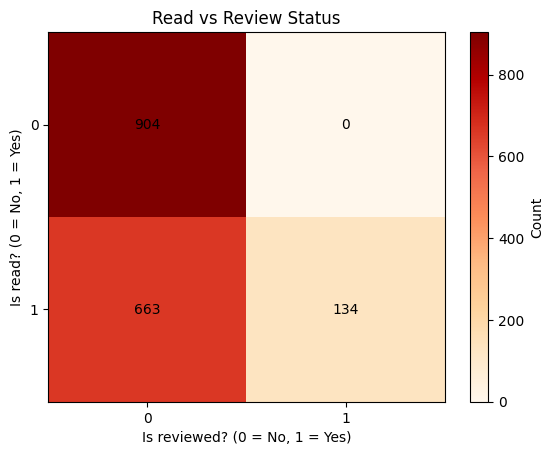

In [11]:
# Create 2D frequency table
heatmap_data = pd.crosstab(interactions_df['is_read'], interactions_df['is_reviewed'])

# Convert to NumPy array for imshow
data_array = heatmap_data.values

# Plot heatmap
plt.imshow(data_array, cmap='OrRd', aspect='auto')

# Add color bar
plt.colorbar(label='Count')

# Set axis labels
plt.title("Read vs Review Status")
plt.xlabel("Is reviewed? (0 = No, 1 = Yes)")
plt.ylabel("Is read? (0 = No, 1 = Yes)")

# Set tick labels
plt.xticks(ticks=range(len(heatmap_data.columns)), labels=heatmap_data.columns)
plt.yticks(ticks=range(len(heatmap_data.index)), labels=heatmap_data.index)

for i in range(data_array.shape[0]):
    for j in range(data_array.shape[1]):
        plt.text(j, i, str(data_array[i, j]), ha='center', va='center', color='black')

plt.show()

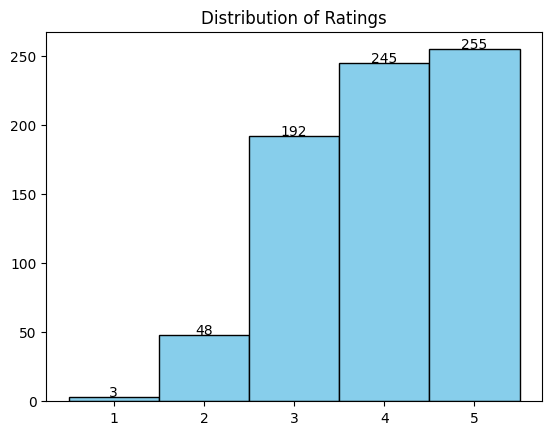

In [12]:
# histogram of ratings
 
plt.title("Distribution of Ratings")
 
counts, bins, patches = plt.hist(interactions_df['rating'], bins=range(1, 7), align='left', edgecolor='black', color='skyblue')
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count + 0.5, int(count), ha='center')

### For genres

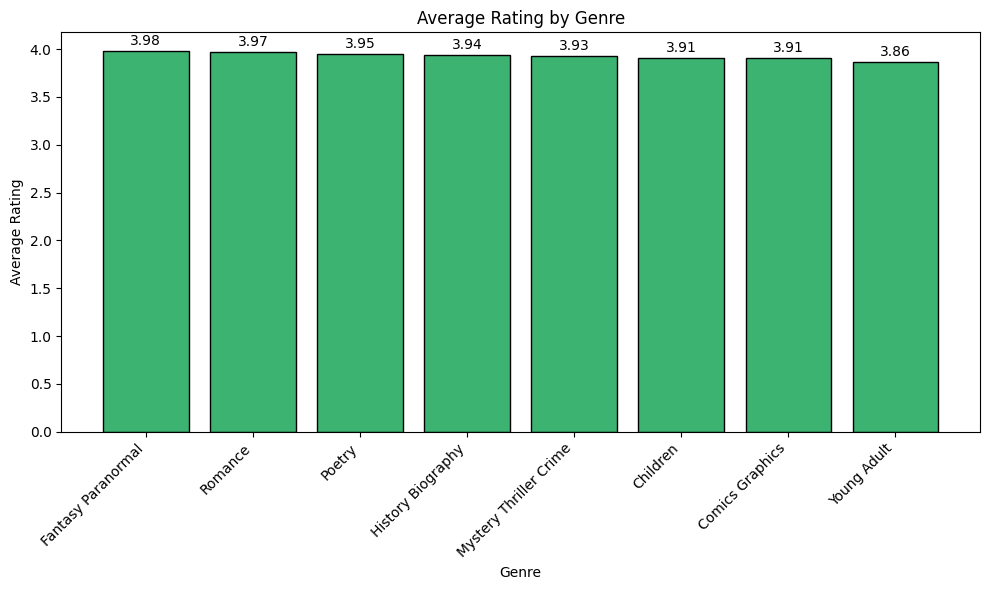

In [20]:
# average rating across the genres

import matplotlib.pyplot as plt

# Step 1: Identify all genre indicator columns
genre_cols = [col for col in genres_df.columns if col.startswith("is_")]

# Step 2: Compute average rating per genre
avg_ratings = {
    col.replace("is_", "").replace("_", " ").title(): genres_df[genres_df[col] == True]['average_rating'].mean()
    for col in genre_cols
}

# Step 3: Convert to Series and sort
avg_ratings_series = pd.Series(avg_ratings).sort_values(ascending=False)

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.bar(avg_ratings_series.index, avg_ratings_series.values, color='mediumseagreen', edgecolor='black')

plt.xticks(rotation=45, ha='right')
plt.title("Average Rating by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.tight_layout()

# Add value labels above bars
for i, v in enumerate(avg_ratings_series.values):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center', va='bottom')

plt.show()




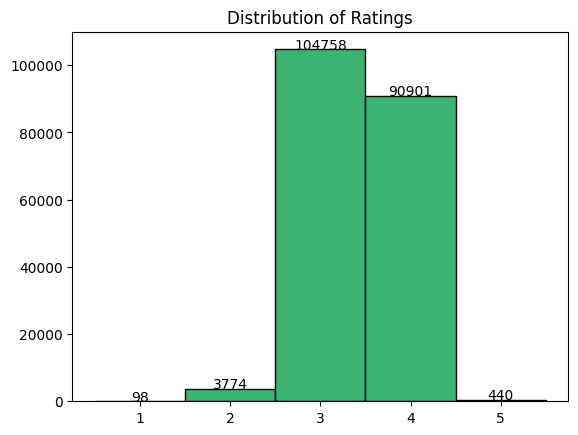

In [22]:
# histogram of ratings across all genres 
 
plt.title("Distribution of Ratings")
 
counts, bins, patches = plt.hist(genres_df['average_rating'], bins=range(1, 7), align='left', edgecolor='black', color='mediumseagreen')
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count + 0.5, int(count), ha='center')